
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, Aggregate_WavesFamilies
from teslakit.extremes import Peaks_Over_Threshold as POT

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation_v2
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT

from teslakit.util.time_operations import xds_reindex_daily, xds_common_dates_daily



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database
site = 'ROI'

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite(site)

p_outputs = p_data + '/sites/' + site + '/ClimateChange_SLR_ENSO/'


In [3]:
# --------------------------------------
# Load data for extremes analysis

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)


# Load Climate Emulator 
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# Load Climate Emulator climate change
CE_CC = Climate_Emulator(p_outputs + 'EXTREMES/climate_emulator/')
CE_CC.Load()

# number of simulations to use
n_sims_DWTs = 10



## Aggregate Waves,  calculate Atmospheric Water Level

In [4]:
# Historical
WVS_hist = Aggregate_WavesFamilies(WVS_fit)
WVS_hist['AWL'] = AWL(WVS_hist.Hs, WVS_hist.Tp)

# Simulations: 1 x ALR_DWTs --> 1 x CE_WAVEs
l_WVS_sim_a = []
l_WVS_sim_b = []
for n in range(n_sims_DWTs):
    
    # Load simulation
    _, _, WVS_upd = CE.LoadSim(n_sim = n)    
    WVS_upd = WVS_upd.isel(n_sim = 0)  # (one CE sim. for each DWT sim.)
    
    # aggregate data, calculate AWL
    WVS_sim_a = Aggregate_WavesFamilies(WVS_upd)
    WVS_sim_a['DWT'] = WVS_upd.DWT 
    WVS_sim_a['AWL'] = AWL(WVS_sim_a.Hs, WVS_sim_a.Tp)
    
    l_WVS_sim_a.append(WVS_sim_a)

    #------------------------------------------
    # Load simulation climate change
    _, _, WVS_upd = CE_CC.LoadSim(n_sim = n)    
    WVS_upd = WVS_upd.isel(n_sim = 0)  # (one CE sim. for each DWT sim.)
    
    # aggregate data, calculate AWL
    WVS_sim_b = Aggregate_WavesFamilies(WVS_upd)
    WVS_sim_b['DWT'] = WVS_upd.DWT 
    WVS_sim_b['AWL'] = AWL(WVS_sim_b.Hs, WVS_sim_b.Tp)
    
    l_WVS_sim_b.append(WVS_sim_b)



## Climate Emulator - Annual Maxima

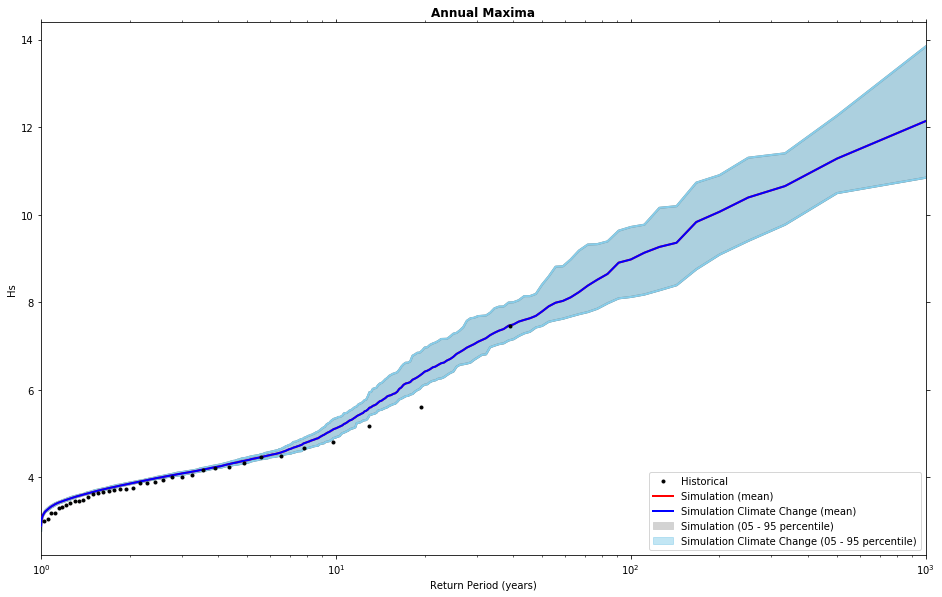

In [5]:
# select variable 
vn = 'Hs'  # Hs, Tp, AWL

# calculate Annual Maxima values for historical and simulated data
hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_a], 'n_sim')
sim_B = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_b], 'n_sim')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation_v2(hist_A, sim_A, sim_B);


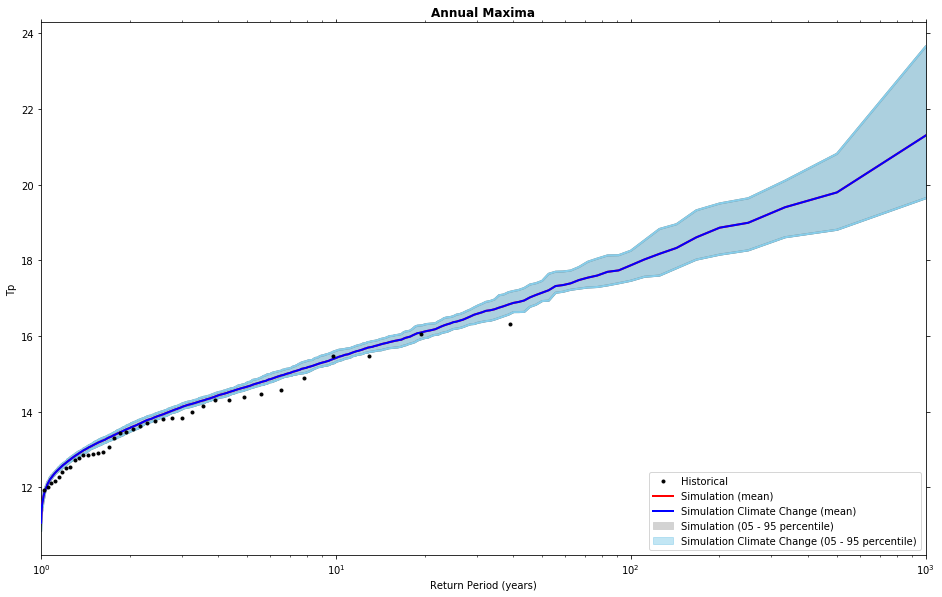

In [6]:
# select variable 
vn = 'Tp'  # Hs, Tp, AWL

# calculate Annual Maxima values for historical and simulated data
hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_a], 'n_sim')
sim_B = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_b], 'n_sim')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation_v2(hist_A, sim_A, sim_B);


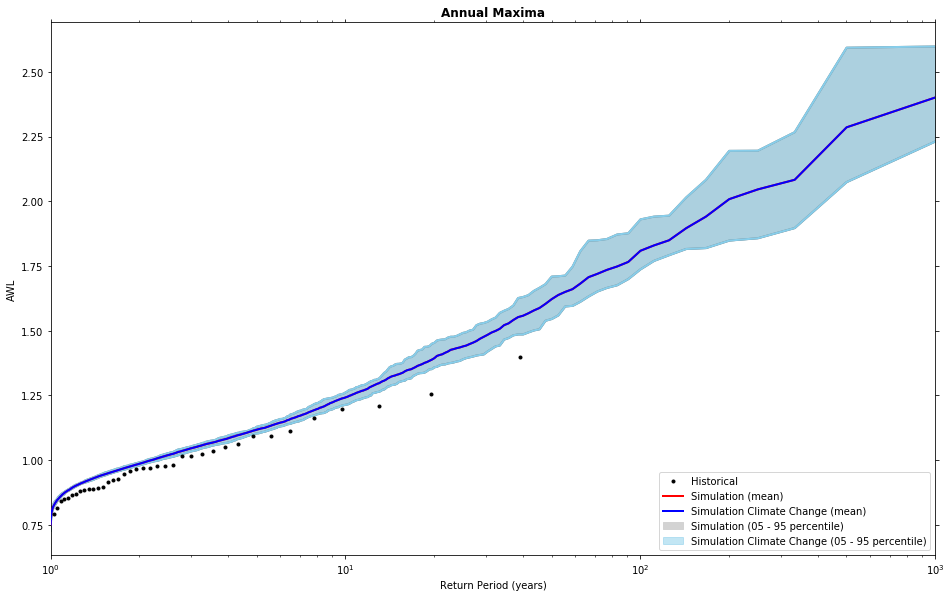

In [7]:
# select variable 
vn = 'AWL'  # Hs, Tp, AWL

# calculate Annual Maxima values for historical and simulated data
hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_a], 'n_sim')
sim_B = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_WVS_sim_b], 'n_sim')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation_v2(hist_A, sim_A, sim_B);


In [8]:
# Annual Maxima Location (for one DWTs/WAVEs simulation)

# index simulation
n_sim = 0 
WVS_sim_a = l_WVS_sim_a[n_sim]
WVS_sim_b = l_WVS_sim_b[n_sim]
#WVS_sim_0 = WVS_sim_a.isel(n_sim=0)  

# aux func to select all dataset variables at max by groups
def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})

# Locate Annual maxima dates
sim_Max_a = WVS_sim_a.groupby('time.year').apply(grouped_max, vn=vn, dim='time').time.values[:]
sim_Max_b = WVS_sim_b.groupby('time.year').apply(grouped_max, vn=vn, dim='time').time.values[:]


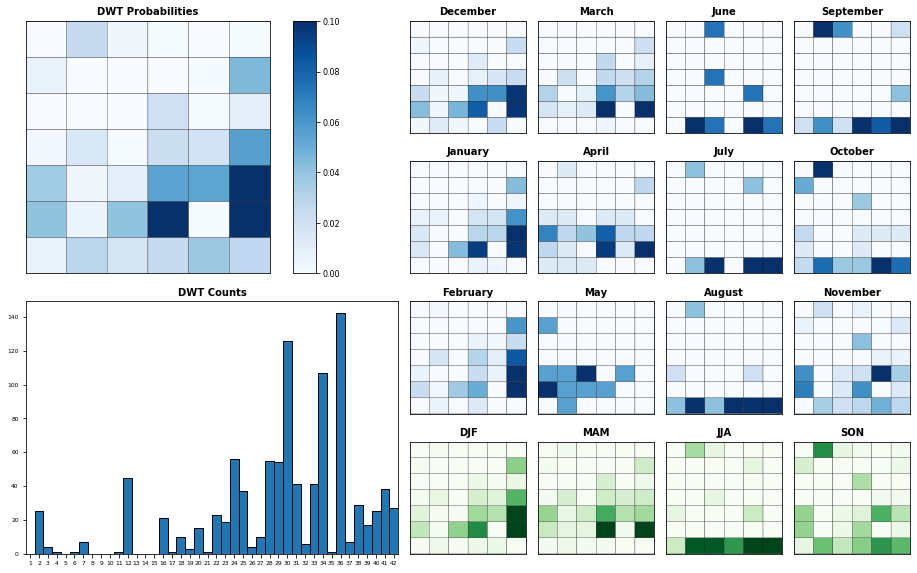

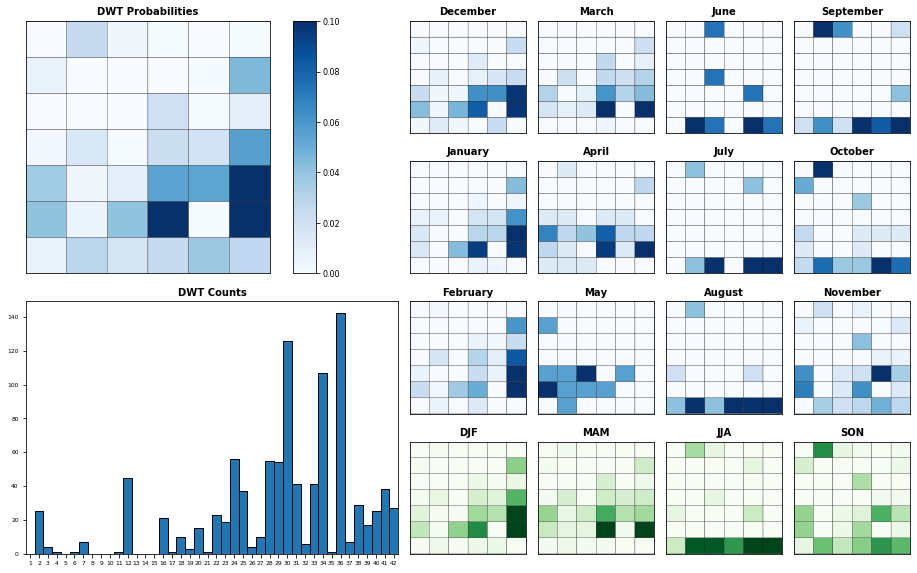

In [9]:
# Annual Maxima DWT probabilities 

n_clusters = 42

# DWTs at AWL annual maxima
sim_DWTs_a = WVS_sim_a.sel(time=sim_Max_a).DWT
sim_DWTs_b = WVS_sim_b.sel(time=sim_Max_b).DWT

# Plot DWTs probabilities by month
Plot_DWTs_Probs(sim_DWTs_a, sim_Max_a, n_clusters);
# Plot DWTs probabilities by month Climate Change
Plot_DWTs_Probs(sim_DWTs_b, sim_Max_b, n_clusters);


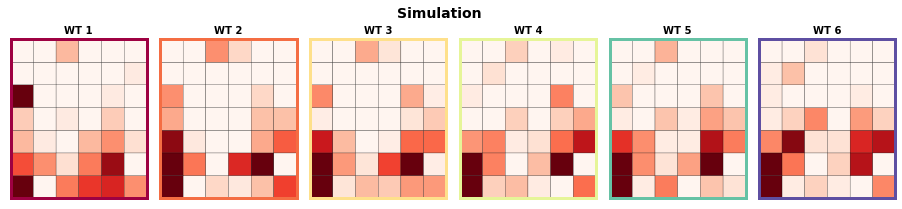

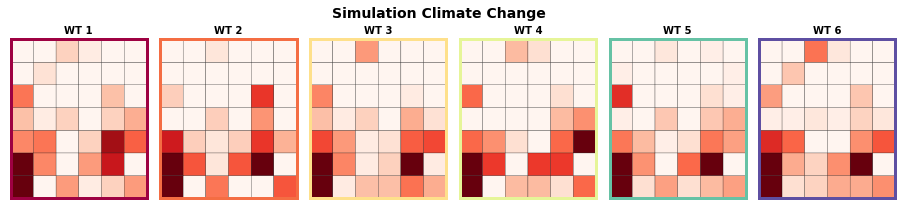

In [10]:
# Annual Maxima AWTs/DWTs Probabilities 

n_clusters_AWT = 6
n_clusters_DWT = 42


#----------------
# simulated

# Load simulated AWTs
AWT_sim_a, _ = db.Load_AWTs_DWTs_Plots_sim(n_sim=n_sim)

# Select data at annual maxima
sim_AWTs_a = AWT_sim_a.sel(time=sim_Max_a).bmus.values[:]


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    sim_AWTs_a, sim_DWTs_a, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation'
);


#----------------
# simulated climate change

#'Load data needed for WT-WT Probs plot'
xds_AWT = xr.open_dataset(p_outputs + 'SST/CC_SST_AWT_sim.nc')
xds_DWT = xr.open_dataset(p_outputs + 'ESTELA/CC_DWT_sim.nc')

# AWT simulated - evbmus_sims -1 
AWT_sim_b = xr.Dataset(
    {'bmus': (('time',), xds_AWT.evbmus_sims.isel(n_sim=n_sim)-1)},
    coords = {'time': xds_AWT.time.values[:]}
)

# DWT simulated - evbmus_sims -1
DWT_sim_b = xr.Dataset(
    {'bmus': (('time',), xds_DWT.evbmus_sims.isel(n_sim=n_sim)-1)},
    coords = {'time': xds_DWT.time.values[:]}
)

# reindex AWT to daily dates (year pad to days)
AWT_sim_b = xds_reindex_daily(AWT_sim_b)

# get common dates
dc = xds_common_dates_daily([AWT_sim_b, DWT_sim_b])
DWT_sim_b = DWT_sim_b.sel(time=slice(dc[0], dc[-1]))
AWT_sim_b = AWT_sim_b.sel(time=slice(dc[0], dc[-1]))

   
# Select data at annual maxima
sim_AWTs_b = AWT_sim_b.sel(time=sim_Max_b).bmus.values[:]


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    sim_AWTs_b, sim_DWTs_b, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation Climate Change'
);



## Climate Emulator - Peaks Over Threshold

In [11]:
# --------------------------------------
# Extremes POT

percentile = 99

# Get independent event peaks
sim_POT_a = POT(WVS_sim_a, vn, percentile)
sim_POT_b = POT(WVS_sim_b, vn, percentile)

# TODO
#Plot_PeaksOverThreshold(hist_POT)
#Plot_PeaksOverThreshold(sim_POT)

In [12]:
# POT Return Period

# TODO
#Plot_ReturnPeriodValidation(hist_POT, sim_POT);


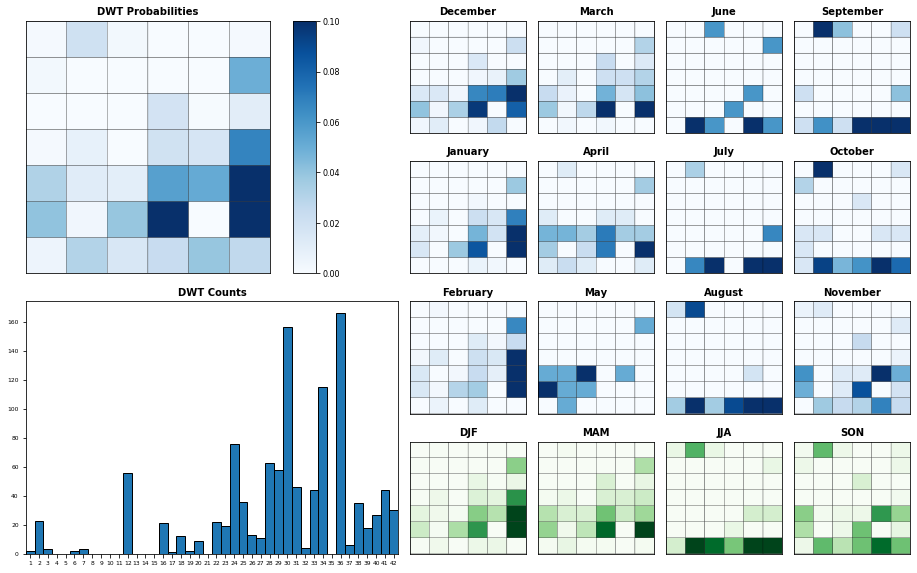

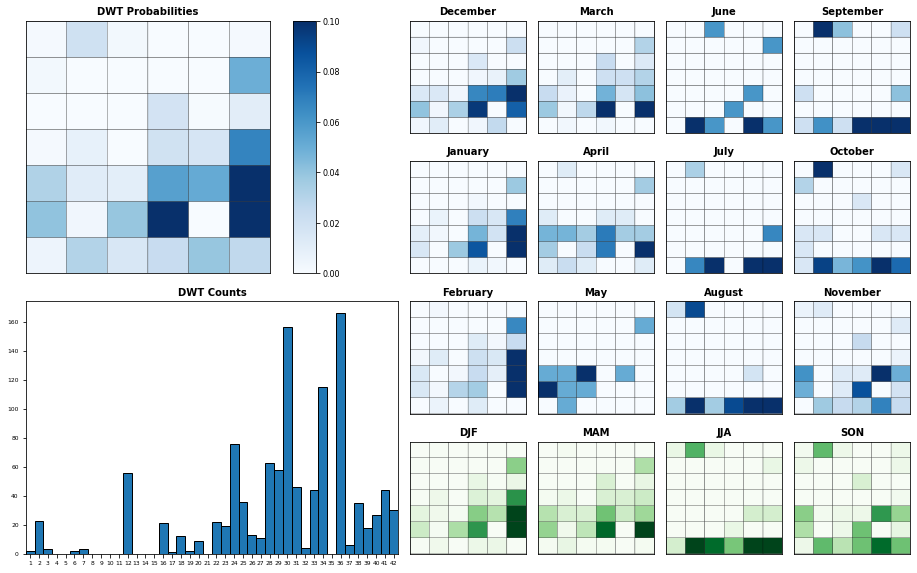

In [13]:
# POT DWT probabilities 

n_clusters = 42

# DWTs at AWL annual maxima
sim_DWTs_a = WVS_sim_a.sel(time=sim_POT_a.time).DWT
sim_DWTs_b = WVS_sim_b.sel(time=sim_POT_b.time).DWT


# Plot DWTs probabilities by month
Plot_DWTs_Probs(sim_DWTs_a, sim_POT_a.time.values[:], n_clusters);
Plot_DWTs_Probs(sim_DWTs_b, sim_POT_b.time.values[:], n_clusters);


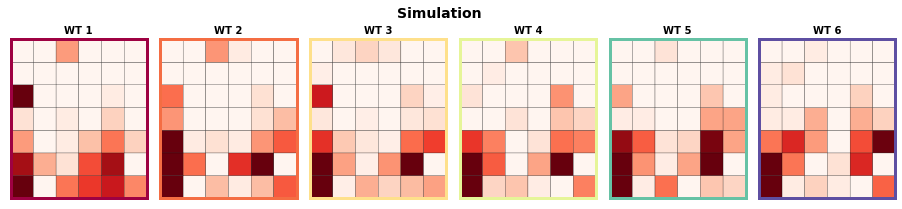

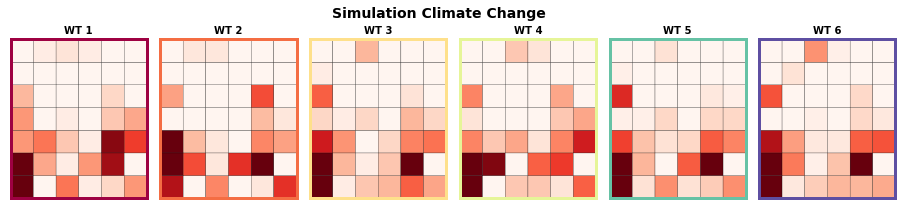

In [14]:
# POT AWTs/DWTs Probabilities 

# Select data at annual maxima
sim_AWTs_a = AWT_sim_a.sel(time=sim_POT_a.time).bmus.values[:]
sim_AWTs_b = AWT_sim_b.sel(time=sim_POT_b.time).bmus.values[:]


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    sim_AWTs_a, sim_DWTs_a, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation'
);
Plot_Probs_WT_WT(
    sim_AWTs_b, sim_DWTs_b, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation Climate Change'
);
